# Auto Insurance Claim Fraud Indicators and Classification

# Mary Donovan Martello

## The goal of this project was to identify significant features in fraudulent insurance claim transactions and to design predictive classification models to predict whether fraud was reported on the insurance claim transaction. This notebook uses a Random Forest model to make the fraud prediciton.

# Part 9:  Random Forest Model

### The dataset includes 1,000 prior claim transaction records.  Each record has a mix of 38 quantitative and categorical data features about the claim filed, including information on the policy, insured, and automobile, aspects of the damage incident, and elements of the claim filed.  The dataset also has a feature that indicates whether fraud was reported on each observation (i.e., either Y or N).

In [2]:
dfClaims = pd.read_csv('FradulentInsuranceClaims.csv')

In [3]:
dfClaims.head(2)

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN


### The dataset includes the original data that was cleaned, prepared, and transformed into Principal Component features in the 1_EDA_Prep notebook.

In [38]:
# import scaled, transformed and PCA df
pcaDF = pd.read_csv('pcaClaimsLog.csv')

# Model Evaluation and Model Selection

> ## Phase 3: Model Selection with Grid Search and K-Fold Cross Validation

In [37]:
# import libraries for models

import pandas as pd
import numpy as np

from numpy import mean
from numpy import std

import yellowbrick
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

#stop unnecessary warnings from printing to the screen
import warnings
warnings.simplefilter('ignore')


C:\Users\trave\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


### Prepare feature matrix and target vector for pipeline modeling.

In [91]:
# now need a different method of encoding categorical variables to make it work in the pipeline

# separate into input and output columns (X variable for features and y for target variables)

X2 = pcaDF.drop('fraud_reported', axis = 1) 
y2 = pcaDF['fraud_reported']
yRF2 = pcaDF['fraud_reported']

# one-hot encode input variables
# use ColumnTransformer to indicate which categorical variables to encode
# https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/
onehot_encoder = OneHotEncoder()
onehot_encoder.fit(X2)
transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 
                                                                        28, 29, 30, 31])], remainder='passthrough')
X2 = transformer.fit_transform(X2)

# ordinal encode target variable
label_encoder = LabelEncoder()
label_encoder.fit(y2)
y2 = label_encoder.transform(y2)

### GridSearch/Cross Validate model (all features): Random Forest

In [116]:
# RF target not encoded - all features
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_validate

# grid search in a pipeline RF

from sklearn.model_selection import GridSearchCV
    
# create random forest classifier model
modelRF = RandomForestClassifier(random_state=1)

paramsRF = {
    'n_estimators': [50, 150, 250],
    'max_features': ['sqrt'],
    'min_samples_split': [2, 4, 6]
}

grid = GridSearchCV(modelRF, paramsRF, cv=5, verbose=0)
scoring = ['accuracy', 'precision_macro', 'recall_macro']

# create a pipeline that standardizes, then runs logistic regression
#pipeline=make_pipeline(standardizer, grid)
pipeline=make_pipeline(grid)
# create k-fold cross-validation
kf= KFold(n_splits=10, shuffle=True, random_state=1)
# conduct a k-fold cross-validation
cv_results=cross_validate(pipeline, # Pipeline
                           X2, # Feature matrix
                           yRF2,#target vector
                           cv=kf, # Cross-validation technique
                           scoring = scoring, # Loss function
                           n_jobs = -1)

print (cv_results)
print("results")

{'fit_time': array([40.92257285, 40.91060376, 40.69617867, 40.96944857, 41.15495253,
       41.56285977, 42.79657865, 41.8012228 , 28.81265235, 28.6570673 ]), 'score_time': array([0.01396322, 0.01396275, 0.0139637 , 0.01396298, 0.01496005,
       0.01695609, 0.06181788, 0.01396275, 0.00897551, 0.01998353]), 'test_accuracy': array([0.78      , 0.78      , 0.7       , 0.81      , 0.72      ,
       0.8       , 0.78      , 0.78      , 0.84848485, 0.72727273]), 'test_precision_macro': array([0.67843137, 0.65555556, 0.61904762, 0.75994695, 0.62470862,
       0.68986569, 0.56666667, 0.76630435, 0.84749553, 0.75955056]), 'test_recall_macro': array([0.6284585 , 0.58158508, 0.57619048, 0.66118421, 0.61122661,
       0.59373116, 0.54065041, 0.6018711 , 0.71583333, 0.60606061])}
results


### GridSearch/Cross Validate model (best subset of features): Random Forest

In [117]:
# RF target not encoded - best subset of features
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_validate

# grid search in a pipeline RF

from sklearn.model_selection import GridSearchCV
    
# create random forest classifier model
modelRF = RandomForestClassifier(random_state=1)

paramsRF = {
    'n_estimators': [50, 150, 250],
    'max_features': ['sqrt'],
    'min_samples_split': [2, 4, 6]
}

grid = GridSearchCV(modelRF, paramsRF, cv=5, verbose=0)
scoring = ['accuracy', 'precision_macro', 'recall_macro']

# create a pipeline that standardizes, then runs logistic regression
#pipeline=make_pipeline(standardizer, grid)
pipeline=make_pipeline(grid)
# create k-fold cross-validation
kf= KFold(n_splits=10, shuffle=True, random_state=1)
# conduct a k-fold cross-validation
cv_results=cross_validate(pipeline, # Pipeline
                           subset11, # Feature matrix
                           yRFsk2,#target vector
                           cv=kf, # Cross-validation technique
                           scoring = scoring, # Loss function
                           n_jobs = -1)

print (cv_results)
print("results")

{'fit_time': array([24.60449958, 25.4292953 , 24.98448563, 25.17996311, 22.49701858,
       22.48904061, 22.33146167, 23.10447812, 18.33399582, 18.0677309 ]), 'score_time': array([0.01595759, 0.04587746, 0.01495981, 0.02991962, 0.01595736,
       0.01595712, 0.02094388, 0.03091788, 0.01296568, 0.00997257]), 'test_accuracy': array([0.77      , 0.81      , 0.79      , 0.81      , 0.75      ,
       0.78      , 0.79      , 0.85      , 0.84848485, 0.74747475]), 'test_precision_macro': array([0.68243243, 0.72983257, 0.75011688, 0.74      , 0.67706748,
       0.67419537, 0.64879792, 0.81112366, 0.79945055, 0.71579477]), 'test_recall_macro': array([0.69819311, 0.76398601, 0.7547619 , 0.74671053, 0.68139293,
       0.68595539, 0.65514905, 0.78638254, 0.7725    , 0.6969697 ])}
results


### Prediction with best subset of features

In [118]:
# now make a prediction from subset of features
# Try cross=validation predict
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

# target not encoded
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_validate

# grid search in a pipeline RF

from sklearn.model_selection import GridSearchCV
    
# create random forest classifier model
modelRF = RandomForestClassifier(random_state=1)

paramsRF = {
    'n_estimators': [50, 150, 250],
    'max_features': ['sqrt'],
    'min_samples_split': [2, 4, 6]
}

grid = GridSearchCV(modelRF, paramsRF, cv=5, verbose=0)

# create a pipeline that standardizes, then runs logistic regression
pipeline=make_pipeline(grid)

# create k-fold cross-validation
kf= KFold(n_splits=10, shuffle=True, random_state=1)

# conduct a k-fold cross-validation
predRFS11=cross_val_predict(pipeline, # Pipeline
                           subset11, # Feature matrix
                           yRFsk2,#target vector
                           cv=kf, # Cross-validation technique
                           n_jobs = -1)

### Confusion Matrix - Random Forest

In [119]:
from sklearn.metrics import confusion_matrix
conf_matRF = confusion_matrix(yRFsk2, predRFS11)
print(conf_matRF)

[[647 104]
 [101 146]]


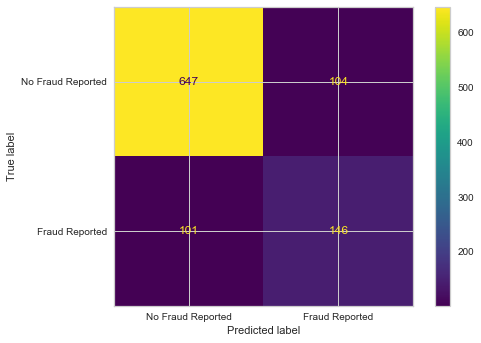

In [120]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
display_labels = ['No Fraud Reported', 'Fraud Reported']
dispRF = ConfusionMatrixDisplay(confusion_matrix=conf_matRF, display_labels=display_labels)
# NOTE: Fill all variables here with default values of the plot_confusion_matrix
dispRF = dispRF.plot(include_values=True)
plt.show()

### Classification Report - Random Forest

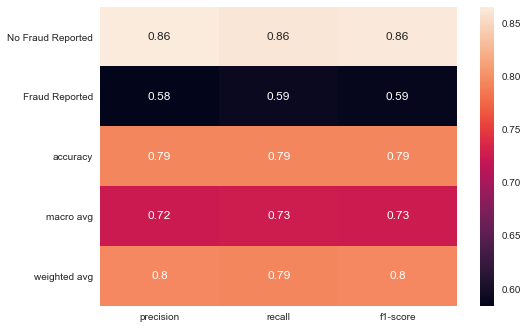

In [122]:
from sklearn.metrics import classification_report
class_repRF = classification_report(yRFsk2, predRFS11, output_dict=True, target_names= ['No Fraud Reported', 'Fraud Reported'])
# Create a dataframe from the dictionary and plot a heatmap of it.
import seaborn as sns
# .iloc[:-1, :] to exclude support
sns.heatmap(pd.DataFrame(class_repRF).iloc[:-1, :].T, annot=True)